# Uncertainty Study of Random Forest Regression Model for Materials Science

Ashley S. Dale

This notebook introduces a simple method of estimating *aleatoric* and *epistemic* uncertainty for random forest regression (RFR) models based on the conservation of variance.

**Epistemic Uncertainty** can be reduced through further information available to the model.

**Aleatoric Uncertainty** cannot be reduced; it is part of the randomness associated with model hyperparameters.

**Total Uncertainty** = Epistemic Uncertainty + Aleatoric Uncertainty

We would like to distinguish between the two so that we can better understand how to select data samples for tasks.  However, estimating the aleatoric uncertainty is challenging.  It is more common to calculate the total uncertainty and epistemic uncertainty, then solve for the aleatoric uncertainty.  

$aleatoric\ uncertainty = (total\ uncertainty) - (epistemic\ uncertainty)$


# Procedure

1. Given a dataset, divide the data into a training and a test set
    - The train set consists of chemistries which do not contain Fe as an element
    - The test set consists of chemistries which *do* contain Fe as an element
2. Train a Random Forest Regression model to predict the energy of formation for these chemistries
3. Estimate the total uncertainty of the predictions
4. Estimate the epistemic uncertainty of the predictions
5. Calculate an estimate of the aleatoric uncertainty for the predictions
6. Identify samples which have low aleatoric and high epistemic uncertainty

In [1]:
%matplotlib inline

In [2]:
import copy
import numpy as np
from tqdm import trange
import pandas as pd
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from data_utils import get_samples_w_element_X

## Load Data

We will use a version of the Jarvis3D DFT dataset.

In [3]:
# Download the data pickle
!chmod 755 get_featurized_data.bash
!./get_featurized_data.bash

--2025-03-03 17:31:54--  https://zenodo.org/record/8200972/files/jarvis22_featurized_matminer.pkl?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/8200972/files/jarvis22_featurized_matminer.pkl [following]
--2025-03-03 17:31:55--  https://zenodo.org/records/8200972/files/jarvis22_featurized_matminer.pkl
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 221565215 (211M) [application/octet-stream]
Saving to: ‘data/jarvis22/dat_featurized_matminer.pkl’

data/jarvis22/dat_f 100%[===================>] 211.30M  4.75MB/s    in 31s     

2025-03-03 17:32:26 (6.83 MB/s) - ‘data/jarvis22/dat_featurized_matminer.pkl’ saved [221565215/221565215]



In [4]:
# Get Data
data = pd.read_pickle('data/jarvis22/dat_featurized_matminer.pkl')
print(len(data))

75993


In [5]:
target = 'e_form'
n_samples = -1 # for all samples, pass -1
element_to_omit_from_training_data = 'Fe'

In [6]:
# This is the list of samples containing the omitted element
sample_list = get_samples_w_element_X(data, 'formula', element_to_omit_from_training_data)

In [7]:
# We will remove any string, dict, or boolean columns
for col_name in data.columns:
    if any([type(i)==str for i in data[col_name].values]): 
        data = data.drop(columns=col_name)
    elif any([type(i)==dict for i in data[col_name].values]):
        data = data.drop(columns=col_name)
    elif any([type(i)==np.bool_ for i in data[col_name].values]):
        data = data.drop(columns=col_name)

# drop colummns with NaN
data = data.dropna(axis=1, how='any')

In [8]:
# Obtain the test data partitions
X_test = data.iloc[sample_list].drop(axis=1, columns=target).values
y_test = data.iloc[sample_list][target].values

In [9]:
# remove test samples from the dataset to make the training partition
train_df = data.drop(axis=0, index=data.iloc[sample_list].index)
train_df

,e_form,bandgap,max packing efficiency,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
jid,,,,,,,,,,,,,,,,,,,,,
JVASP-44433,-2.08566,2.816,0.381419,4,0.596131,0.523542,0.481103,0.467079,0.459205,3.0,...,12.0,229.0,217.0,146.909091,98.115702,229.0,0.314815,0.351852,0.074074,0.259259
JVASP-18098,-0.43127,0.000,0.573704,3,0.577350,0.480750,0.415244,0.389977,0.372041,12.0,...,139.0,194.0,55.0,166.333333,18.444444,139.0,0.260870,0.043478,0.434783,0.260870
JVASP-104924,-0.00880,0.000,0.733723,2,0.707107,0.629961,0.574349,0.552045,0.535887,20.0,...,225.0,225.0,0.0,225.000000,0.000000,225.0,1.000000,0.000000,0.000000,0.000000
JVASP-68888,0.37300,0.000,0.637880,3,0.577350,0.480750,0.415244,0.389977,0.372041,4.0,...,194.0,229.0,35.0,217.333333,15.555556,194.0,0.416667,0.000000,0.583333,0.000000
JVASP-106319,-0.84115,0.000,0.523834,3,0.577350,0.480750,0.415244,0.389977,0.372041,31.0,...,64.0,225.0,161.0,161.000000,64.666667,64.0,0.121951,0.024390,0.512195,0.341463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JVASP-18721,-0.17250,0.000,0.680175,3,0.612372,0.538609,0.506099,0.501109,0.500098,12.0,...,194.0,225.0,31.0,209.500000,15.500000,225.0,0.166667,0.000000,0.833333,0.000000
JVASP-17562,-0.48034,0.000,0.446920,3,0.663325,0.614463,0.600984,0.600078,0.600002,5.0,...,166.0,225.0,59.0,207.000000,21.600000,225.0,0.108108,0.027027,0.837838,0.027027
JVASP-19675,-0.20773,0.000,0.513224,2,0.745356,0.693361,0.670782,0.667408,0.666732,33.0,...,166.0,229.0,63.0,187.000000,28.000000,166.0,0.138889,0.166667,0.694444,0.000000


In [10]:
# visualize the training distributions
y_train = train_df[target].values
X_train = train_df.drop(columns=[target]).values

## Train the Random Forest Regression Model

In [11]:
# These are the hyperparameters for the random forest
num_trees_in_forest = 100
max_feat = 0.1
num_dataset_features = X_test.shape[1]

In [12]:
# Initialize the random forest regressor
model = RandomForestRegressor(
    n_estimators=num_trees_in_forest, 
    max_features=max_feat,
    oob_score=True
)

In [13]:
# Fit the model
model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.1, oob_score=True)

In [14]:
# Predict values for the training dataset
y_pred_gt = model.predict(X_train)

In [15]:
# Predict values for the testing dataset
y_pred = model.predict(X_test)

In [16]:
test_predictions = []
train_predictions = []

# Get the predictions from each tree in the forest
for tree_obj in tqdm(model.estimators_, total = model.n_estimators):
    test_predictions.append(tree_obj.tree_.predict(X_test.astype(np.float32)))
    train_predictions.append(tree_obj.tree_.predict(X_train.astype(np.float32)))

100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


In [17]:
set_of_train_predictions = np.transpose(np.squeeze(np.array(train_predictions)))
mean_of_ea_train_pred = np.mean(set_of_train_predictions, axis=1)

In [18]:
set_of_test_predictions = np.transpose(np.squeeze(np.array(test_predictions)))
mean_of_ea_test_pred = np.mean(set_of_test_predictions, axis=1)

In [19]:
def variance_estimate(y, y_hat, n=None):
    if n == None:
        n = len(y_hat)
    return np.sum(np.power((y - y_hat), 2))/n

def get_variance_estimate(true_values, predicted_values):
    var = []
    for sample_idx in trange(len(true_values)):
        var.append(variance_estimate(true_values[sample_idx],predicted_values[sample_idx, :] ))
    return np.array(var)


# Calculate Total Uncertainty for Each Sample

The total uncertainty for each prediction from a Random Forest Regression model is commonly estimated using the Mean Squared Error of the prediction. For each prediction $y_i$ from the $i^\text{th}$ tree out of $n$ trees in the Random Forest and the target value $y$:

$\sigma^2 = \frac{1}{n} \Sigma_n \left( y - y_i\right )^2$

In [20]:
train_mse = get_variance_estimate(y_train, set_of_train_predictions)
test_mse = get_variance_estimate(y_test, set_of_test_predictions)

100%|██████████| 4083/4083 [00:00<00:00, 79493.40it/s]


## Calculate Epistemic Uncertainty

The epistemic uncertainty for a Random Forest Regression model is approximated using the variance in predictions across all trees. Given a mean predicted value $\bar{y}$ from the set of predictions $y_i$ from the $i^\text{th}$ 

$\bar{y} = \frac{1}{n} \Sigma_n \left(y_i\right)^2$

The variance in predictions between all trees in the forest is

$\sigma_\text{epi}^2 = \frac{1}{n} \Sigma_n (y_i - \bar{y})^2$

In [21]:
train_explained_var = get_variance_estimate(mean_of_ea_train_pred, set_of_train_predictions)
test_explained_var = get_variance_estimate(mean_of_ea_test_pred, set_of_test_predictions)

100%|██████████| 4083/4083 [00:00<00:00, 79089.57it/s]


# Calculate Aleatoric Uncertainty

To obtain an estimate of the aleatoric uncertainty $\sigma_\text{al}^2$, we obtain the difference between the total uncertainty and the prediction variance:

$\sigma_\text{al}^2 = \sigma^2 - \sigma_\text{epi}^2$

In [22]:
train_diff_var = train_mse - train_explained_var
test_diff_var = test_mse - test_explained_var

# Visualize Results

The first thing we want to do is to visualize the distributions for the calculated uncertainties:

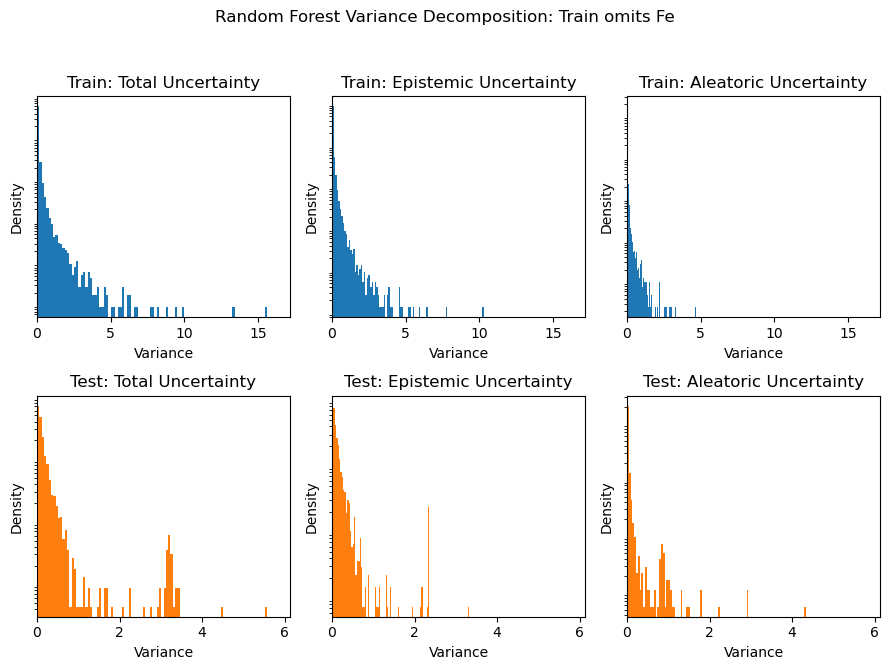

In [23]:
x_ax_max_train = 1.1*np.amax(train_mse)
x_ax_max_test = 1.1*np.amax(test_mse)

fig, ax = plt.subplots(2, 3, figsize=(9, 7))

ax[0, 0].set_title('Train: Total Uncertainty')
ax[0, 0].hist(train_mse, 100, density=True)
ax[0, 0].set_xlim(0, x_ax_max_train)

ax[0, 1].set_title('Train: Epistemic Uncertainty')
ax[0, 1].hist(train_explained_var, 100, density=True)
ax[0, 1].set_xlim(0, x_ax_max_train)

ax[0, 2].set_title('Train: Aleatoric Uncertainty')
ax[0, 2].hist(train_diff_var, 100, density=True)
ax[0, 2].set_xlim(0, x_ax_max_train)

ax[1, 0].set_title('Test: Total Uncertainty')
ax[1, 0].hist(test_mse, 100, density=True, color='C1')
ax[1, 0].set_xlim(0, x_ax_max_test)

ax[1, 1].set_title('Test: Epistemic Uncertainty')
ax[1, 1].hist(test_explained_var, 100, density=True, color='C1')
ax[1, 1].set_xlim(0, x_ax_max_test)

ax[1, 2].set_title('Test: Aleatoric Uncertainty')
ax[1, 2].hist(test_diff_var, 100, density=True, color='C1')
ax[1, 2].set_xlim(0, x_ax_max_test)

for i in ax.flatten():
    i.set_xlabel('Variance')
    i.set_ylabel('Density')
    i.set_yscale('log')
    i.set_yticks([], minor=False)
    i.set_yticklabels([])

fig.suptitle(f'Random Forest Variance Decomposition: Train omits {element_to_omit_from_training_data}')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Next, we visualize the total uncertainty estimate for each prediction by creating a parity plot with error bars.  To preserve units, the error bars are presented using the standard devation of the total uncertainty for each sample:

$\sigma = \sqrt{\frac{1}{n}\Sigma_n \left(y - y_i \right)^2}$

Text(0.5, 0.98, 'Random Forest Predictions: Train omits Fe')

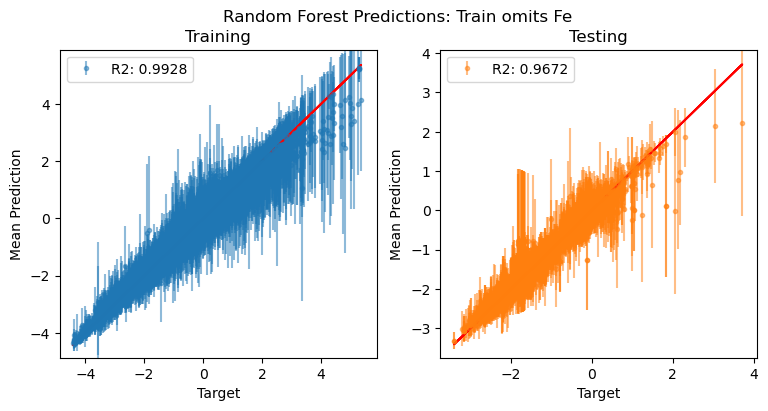

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].errorbar(
    y_train, mean_of_ea_train_pred, yerr=np.sqrt(train_mse), 
    fmt='.', linestyle=None, alpha=0.5, label='R2: ' +str(r2(y_train, mean_of_ea_train_pred))[:6]
    )
ax[0].plot(y_train, y_train, 'r')
ax[0].set_title('Training')
ax[0].set_xlabel('Target')
ax[0].set_ylabel('Mean Prediction')
ax[0].set_xlim(1.1*np.amin(y_train), 1.1*np.amax(y_train))
ax[0].set_ylim(1.1*np.amin(y_train), 1.1*np.amax(y_train))
ax[0].legend()

ax[1].errorbar(
    y_test, mean_of_ea_test_pred, yerr=np.sqrt(test_mse), 
    fmt='.', linestyle=None, alpha=0.5, color='C1',  label='R2: ' +str(r2(y_test, mean_of_ea_test_pred))[:6]
    )

ax[1].plot(y_test, y_test, 'r')
ax[1].set_title('Testing')
ax[1].set_xlabel('Target')
ax[1].set_ylabel('Mean Prediction')
ax[1].set_xlim(1.1*np.amin(y_test), 1.1*np.amax(y_test))
ax[1].set_ylim(1.1*np.amin(y_test), 1.1*np.amax(y_test))
ax[1].legend()

fig.suptitle(f'Random Forest Predictions: Train omits {element_to_omit_from_training_data}')

We can also visualize the distributions of the standard deviation:

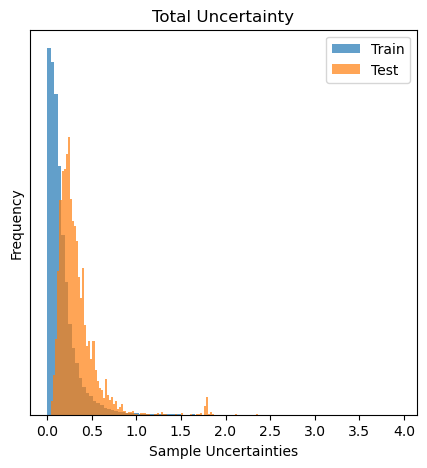

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = ax.hist(np.sqrt(train_mse), 100, density=True, alpha=0.7, label='Train')
_ = ax.hist(np.sqrt(test_mse), 100, density=True, alpha=0.7, label='Test')
ax.set_yticks(())
ax.set_xlabel('Sample Uncertainties')
ax.set_ylabel('Frequency')
ax.set_title('Total Uncertainty')
ax.legend()
plt.show()

Finally, we can can check for correlation between epistemic and aleatoric uncertainty:

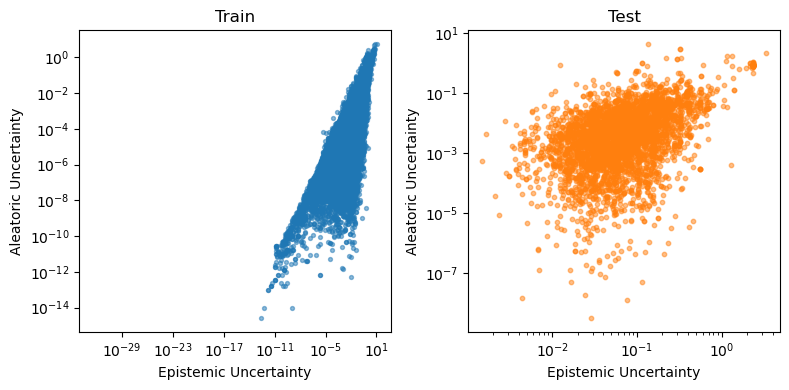

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].scatter(train_explained_var, train_diff_var, alpha=0.5, color='C0', label='Train', s=8)
ax[0].set_xlabel('Epistemic Uncertainty')
ax[0].set_ylabel('Aleatoric Uncertainty')
ax[0].set_title('Train')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].scatter(test_explained_var, test_diff_var, alpha=0.5, color='C1', label='Test', s=10)
ax[1].set_xlabel('Epistemic Uncertainty')
ax[1].set_ylabel('Aleatoric Uncertainty')
ax[1].set_title('Test')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
fig.tight_layout()
plt.show()